Dataset:
- ✅ Outliers extremos en un 3% de los datos (valores multiplicados por 5-10x).
- ✅ Valores claramente incorrectos en columnas clave (ej. OxygenSaturation con valores de 200%).
- ✅ Errores de digitación en variables categóricas (Present → Presnt, Epithelial → Epthlial).
- ✅ Intercambio de valores entre columnas (CellSize ↔ MitosisRate para simular errores de ingreso de datos).
- ✅ Más valores nulos (10%) en distintas features.
- ✅ Datos duplicados con pequeñas variaciones para simular mediciones imprecisas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

In [2]:
# Cargar el dataset
df = pd.read_csv("data/dataset_sintetico_ensuciado_final.csv")

In [3]:
df.head()

,CellSize,CellShape,NucleusDensity,ChromatinTexture,CytoplasmSize,CellAdhesion,MitosisRate,NuclearMembrane,GrowthFactor,OxygenSaturation,Vascularization,InflammationMarkers,Diagnosis,CellType,GeneticMutation
0,69.205741,NaN,NaN,19.486388,NaN,0.504198,2.775478,2.483680,60.828601,79.834458,4.969965,43.340923,1.0,Epthlial,Absnt
1,66.943834,0.469704,1.514241,21.274073,24.696911,0.444878,3.588188,2.413884,NaN,78.950032,5.166816,45.928559,0.0,???,Absnt
2,NaN,0.550268,1.480066,21.144604,24.658103,0.452984,3.495889,2.456517,59.317274,NaN,5.089109,45.415866,0.0,Mesnchymal,Absnt
3,484.230717,2.693941,10.698417,228.929540,216.155904,4.253458,16.753481,23.766783,441.960592,584.755628,30.413694,213.810039,0.0,Mesnchymal,Absnt
4,NaN,0.489484,1.537086,19.691086,28.195683,0.440572,3.478935,2.544128,56.951441,NaN,5.769709,47.417237,0.0,Mesnchymal,Presnt


In [4]:
df.describe()

,CellSize,CellShape,NucleusDensity,ChromatinTexture,CytoplasmSize,CellAdhesion,MitosisRate,NuclearMembrane,GrowthFactor,OxygenSaturation,Vascularization,InflammationMarkers,Diagnosis
count,1483.000000,1491.000000,1515.000000,1516.000000,1499.000000,1525.000000,1492.000000,1503.000000,1504.000000,1529.000000,1492.000000,1507.000000,1848.000000
mean,85.233522,0.600954,2.129402,26.204710,34.192421,0.554454,5.388740,2.844692,74.365989,93.617820,6.011857,47.729977,0.450216
std,107.697793,0.598316,5.077409,24.975800,33.308259,0.620148,11.777124,2.744619,78.447125,84.205474,5.802502,44.051566,0.497650
min,-100.000000,-3.510377,-3.000000,10.000000,5.000000,-4.461755,-50.000000,-3.438990,-50.000000,-10.000000,-0.997057,0.000000,0.000000
25%,66.527105,0.478983,1.397509,21.276428,26.375013,0.456318,2.781267,2.251211,58.168971,79.143124,4.787725,37.488908,0.000000
50%,69.650663,0.499050,1.446471,22.068669,28.403605,0.475327,3.106660,2.416263,60.992806,80.001376,5.069671,40.881011,0.000000
75%,72.657457,0.523394,1.486895,22.828501,30.554284,0.493967,3.427686,2.536056,63.058152,80.994767,5.351401,43.992433,1.000000
max,1000.000000,5.048566,50.000000,263.793425,299.350559,5.029925,100.000000,24.871762,563.622684,807.181058,54.512433,440.902261,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CellSize             1483 non-null   float64
 1   CellShape            1491 non-null   float64
 2   NucleusDensity       1515 non-null   float64
 3   ChromatinTexture     1516 non-null   float64
 4   CytoplasmSize        1499 non-null   float64
 5   CellAdhesion         1525 non-null   float64
 6   MitosisRate          1492 non-null   float64
 7   NuclearMembrane      1503 non-null   float64
 8   GrowthFactor         1504 non-null   float64
 9   OxygenSaturation     1529 non-null   float64
 10  Vascularization      1492 non-null   float64
 11  InflammationMarkers  1507 non-null   float64
 12  Diagnosis            1848 non-null   float64
 13  CellType             1561 non-null   object 
 14  GeneticMutation      1848 non-null   object 
dtypes: float64(13), object(2)
memory usage

54% clase 0

46% clase 1

In [6]:
# Contar las muestras por clase en la variable objetivo
class_counts = df['Diagnosis'].value_counts()

# Mostrar la cantidad de muestras por clase
print("Cantidad de muestras por clase en 'Diagnosis':")
print(class_counts)

Cantidad de muestras por clase en 'Diagnosis':
Diagnosis
0.0    1016
1.0     832
Name: count, dtype: int64


## Versión 1: Sin feature engineering

In [7]:
# Separar variables predictoras y objetivo
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

In [8]:
# Separar en conjunto de entrenamiento y prueba antes de la imputación para evitar data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [9]:
# Imputación de valores faltantes con la media para variables numéricas
imputer = SimpleImputer(strategy="mean")
X_train_continuous = X_train.select_dtypes(include=['float64', 'int64'])
X_test_continuous = X_test.select_dtypes(include=['float64', 'int64'])

In [10]:
X_train_continuous_imputed = pd.DataFrame(imputer.fit_transform(X_train_continuous), 
                                          columns=X_train_continuous.columns)
X_test_continuous_imputed = pd.DataFrame(imputer.transform(X_test_continuous), 
                                         columns=X_test_continuous.columns)

In [11]:
# One-hot encoding para variables categóricas
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_categorical = X_train.select_dtypes(include=['object'])
X_test_categorical = X_test.select_dtypes(include=['object'])

X_train_categorical_encoded = pd.DataFrame(encoder.fit_transform(X_train_categorical), 
                                           columns=encoder.get_feature_names_out(X_train_categorical.columns))
X_test_categorical_encoded = pd.DataFrame(encoder.transform(X_test_categorical), 
                                          columns=encoder.get_feature_names_out(X_test_categorical.columns))

In [12]:
# Concatenar variables procesadas
X_train_processed = pd.concat([X_train_continuous_imputed, X_train_categorical_encoded], axis=1)
X_test_processed = pd.concat([X_test_continuous_imputed, X_test_categorical_encoded], axis=1)

In [13]:
X_train_processed.head(5)

,CellSize,CellShape,NucleusDensity,ChromatinTexture,CytoplasmSize,CellAdhesion,MitosisRate,NuclearMembrane,GrowthFactor,OxygenSaturation,Vascularization,InflammationMarkers,CellType_Epthlial,CellType_Mesnchymal,CellType_nan,GeneticMutation_Presnt
0,68.587381,0.490554,1.400572,27.174841,29.785316,0.495700,2.754471,2.331812,59.896271,78.919453,4.619820,40.709521,1.0,0.0,0.0,0.0
1,87.503869,0.523981,1.501383,21.256898,25.822200,0.431716,3.568266,2.472518,58.799903,78.747542,6.175551,44.363955,0.0,1.0,0.0,1.0
2,71.538580,0.518771,1.409668,21.186437,28.086426,0.487367,2.971311,2.372260,63.167273,82.543896,6.175551,48.633249,1.0,0.0,0.0,0.0
3,75.098269,0.490802,1.376373,22.915091,31.152946,0.446724,2.711944,2.097559,75.870044,77.994777,4.781083,33.263062,0.0,0.0,0.0,1.0
4,68.404744,0.505548,1.482050,22.252172,29.031348,0.573276,5.619235,2.577650,57.125500,95.401177,4.962536,41.351270,0.0,1.0,0.0,1.0


In [14]:
# Normalizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

### --- MODELO DE REGRESIÓN LOGÍSTICA ---

In [15]:
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train)

# --- EVALUACIÓN DEL MODELO ---
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calcular métricas
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_pred_proba),
    "AUC-PR": average_precision_score(y_test, y_pred_proba),
}

# Convertir métricas en DataFrame
df_metrics = pd.DataFrame(metrics, index=["Logistic Regression"])
print(df_metrics)


                     Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
Logistic Regression   0.67027   0.732143  0.471264  0.573427  0.797209   

                       AUC-PR  
Logistic Regression  0.726249  


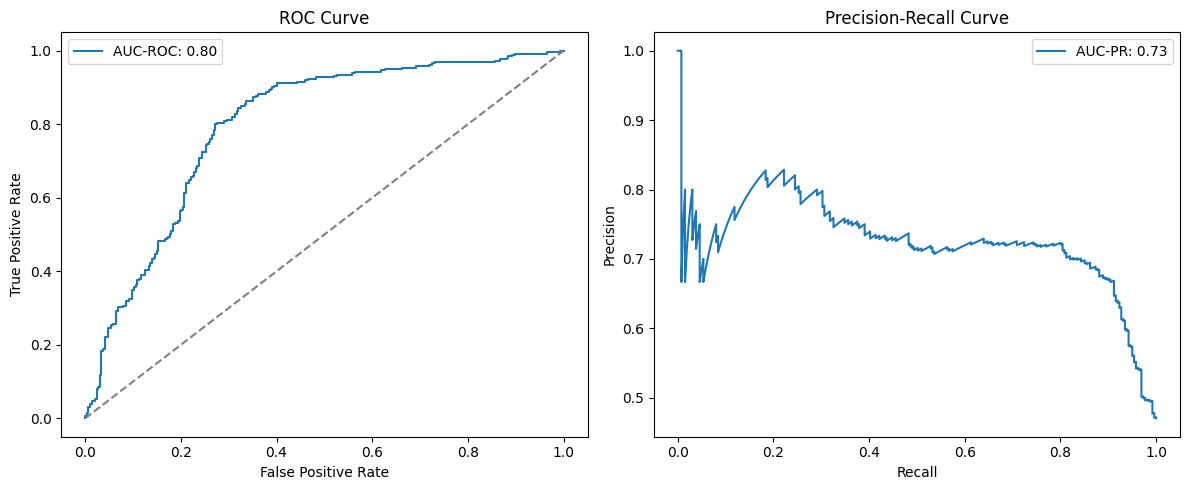

In [16]:
# --- CURVAS ROC y PR ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax[0].plot(fpr, tpr, label=f"AUC-ROC: {metrics['AUC-ROC']:.2f}")
ax[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC Curve")
ax[0].legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax[1].plot(recall, precision, label=f"AUC-PR: {metrics['AUC-PR']:.2f}")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve")
ax[1].legend()

plt.tight_layout()
plt.show()

## Version 2: Con Feature Engineering y Limpieza de Datos

In [17]:
# Cargar el dataset denuevo 
df = pd.read_csv("data/dataset_sintetico_ensuciado_final.csv")

In [18]:
# Eliminar outliers usando IQR
def remove_outliers(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[mask]

In [19]:
num_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
df = remove_outliers(df, num_columns)

In [20]:
# Corregir valores imposibles
df['OxygenSaturation'] = df['OxygenSaturation'].clip(50, 100)  # Saturación debe estar entre 50 y 100
df['MitosisRate'] = df['MitosisRate'].clip(0, 20)  # No puede ser negativa ni extremadamente alta
df['CellSize'] = df['CellSize'].clip(5, 200)  # Tamaño celular dentro de un rango lógico


In [21]:
# Unificar valores en variables categóricas
if 'CellType' in df.columns:
    df['CellType'] = df['CellType'].replace({
        'Epthlial': 'Epithelial',
        'Mesnchymal': 'Mesenchymal',
        '???': 'Unknown'
    })

if 'GeneticMutation' in df.columns:
    df['GeneticMutation'] = df['GeneticMutation'].replace({
        'Presnt': 'Present',
        'Absnt': 'Absent',
        'Error': 'Unknown'
    })

In [22]:
# Separar variables predictoras y objetivo
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

In [23]:
# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Imputación de valores faltantes con la media para variables numéricas
imputer = SimpleImputer(strategy="mean")
X_train_continuous = X_train.select_dtypes(include=['float64', 'int64'])
X_test_continuous = X_test.select_dtypes(include=['float64', 'int64'])

X_train_continuous_imputed = pd.DataFrame(imputer.fit_transform(X_train_continuous), 
                                          columns=X_train_continuous.columns)
X_test_continuous_imputed = pd.DataFrame(imputer.transform(X_test_continuous), 
                                         columns=X_test_continuous.columns)


In [25]:
# One-hot encoding para variables categóricas
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_categorical = X_train.select_dtypes(include=['object']).fillna("Missing")
X_test_categorical = X_test.select_dtypes(include=['object']).fillna("Missing")

X_train_categorical_encoded = pd.DataFrame(encoder.fit_transform(X_train_categorical), 
                                           columns=encoder.get_feature_names_out(X_train_categorical.columns))
X_test_categorical_encoded = pd.DataFrame(encoder.transform(X_test_categorical), 
                                          columns=encoder.get_feature_names_out(X_test_categorical.columns))

In [26]:
# Concatenar variables procesadas
X_train_processed = pd.concat([X_train_continuous_imputed, X_train_categorical_encoded], axis=1)
X_test_processed = pd.concat([X_test_continuous_imputed, X_test_categorical_encoded], axis=1)

In [27]:
# Normalizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

#### --- MODELO DE REGRESIÓN LOGÍSTICA ---

In [28]:
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train)

# --- EVALUACIÓN DEL MODELO ---
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calcular métricas
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_pred_proba),
    "AUC-PR": average_precision_score(y_test, y_pred_proba),
}

# Convertir métricas en DataFrame
df_metrics = pd.DataFrame(metrics, index=["Logistic Regression"])
print(df_metrics)

                     Accuracy  Precision   Recall  F1-Score   AUC-ROC  \
Logistic Regression  0.934641   0.888393  0.97549  0.929907  0.950192   

                       AUC-PR  
Logistic Regression  0.895543  


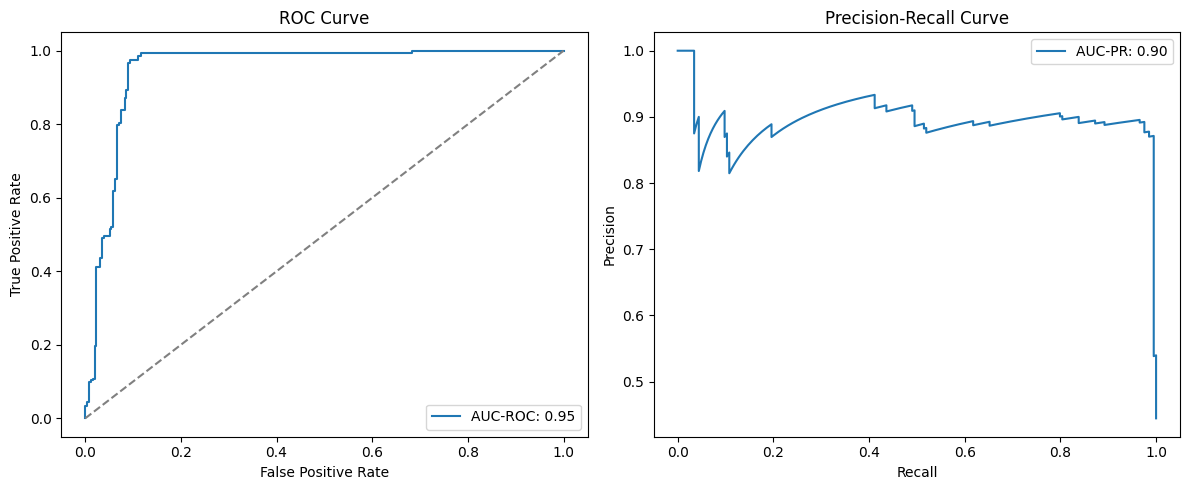

In [29]:
# --- CURVAS ROC y PR ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax[0].plot(fpr, tpr, label=f"AUC-ROC: {metrics['AUC-ROC']:.2f}")
ax[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC Curve")
ax[0].legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax[1].plot(recall, precision, label=f"AUC-PR: {metrics['AUC-PR']:.2f}")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve")
ax[1].legend()

plt.tight_layout()
plt.show()